Core parameters

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import numpy as np

# Network parameters (Watts–Strogatz)
N       = 1000   # number of agents/nodes
k       = 6      # each node connected to k nearest neighbours (must be even)

# Sharing behaviour
p_H  = 0.6       # share when believed human-written
p_AI = 0.2       # share when recognised as AI-generated

# Dynamics parameters
T_max      = 50  # maximum number of time steps
n_runs     = 100 # number of independent realizations
rng_seed   = 123 # for reproducibility
rng = np.random.default_rng(rng_seed)

detection_regimes = ["low", "medium", "high"]
p_rewire_values   = [0.01, 0.1]


Generate Watts–Strogatz small-world network

In [ ]:
def generate_ws_adjacency(N, k, p_rewire, rng):
    """
    Generate an undirected Watts–Strogatz small-world network adjacency matrix.
    Follows the steps from Exercise 12.2 in the course book and HW3 Q4.
    """
    assert k % 2 == 0, "k must be even."
    A = np.zeros((N, N), dtype=int)

    # 1. Regular ring: connect each node to k/2 neighbours on each side
    half_k = k // 2
    for i in range(N):
        for d in range(1, half_k + 1):
            j = (i + d) % N
            A[i, j] = 1
            A[j, i] = 1  # undirected

    # 2. Rewire each edge (i, j) with probability p_rewire
    for i in range(N):
        for d in range(1, half_k + 1):
            j = (i + d) % N
            if A[i, j] == 1:
                if rng.random() < p_rewire:
                    # Remove existing edge
                    A[i, j] = 0
                    A[j, i] = 0

                    # Choose a new node l to connect i to:
                    # - not equal to i
                    # - not already connected to i
                    candidates = np.where(A[i] == 0)[0]
                    candidates = candidates[candidates != i]
                    # For safety, if no candidates, keep original connection
                    if len(candidates) == 0:
                        A[i, j] = 1
                        A[j, i] = 1
                    else:
                        l = rng.choice(candidates)
                        A[i, l] = 1
                        A[l, i] = 1
    return A

Agent state init

In [3]:
def initialize_detection(N, rng, regime):
    """
    Initialize detection abilities d_i for all agents, based on a regime label.
    Regimes:
        'low'    -> mean d ~ 0.1
        'medium' -> mean d ~ 0.5
        'high'   -> mean d ~ 0.9
    Uses Beta(α, β) with appropriate parameters.
    """
    if regime == "low":
        alpha_d, beta_d = 1.0, 9.0
    elif regime == "medium":
        alpha_d, beta_d = 5.0, 5.0
    elif regime == "high":
        alpha_d, beta_d = 9.0, 1.0
    else:
        raise ValueError(f"Unknown detection regime: {regime}")
    d = rng.beta(alpha_d, beta_d, size=N)
    return d


def choose_seed(N, rng):
    """Seed the process with one random initial agent (the first recipient of the AI text)."""
    return rng.integers(0, N)

Single simulation run (diffusion dynamics)

In [ ]:
def run_single_simulation(neighbors, N, rng,
                          d,           # detection array d_i
                          p_H, p_AI,
                          T_max):
    """
    Run a single simulation of AI-generated text diffusion on a fixed network.
    neighbors: list of neighbor index arrays for each node
    d: detection probabilities for each agent
    """
    # Agent state
    received = np.zeros(N, dtype=bool)
    shared   = np.zeros(N, dtype=bool)

    # Choose seed
    seed = choose_seed(N, rng)
    received[seed] = True
    shared[seed]   = True
    active_sharers = np.array([seed], dtype=int)

    # Time-series tracking (for optional plots)
    num_active      = []
    num_cum_shared  = []
    num_reached     = []

    for t in range(T_max):
        num_active.append(active_sharers.size)
        num_cum_shared.append(shared.sum())
        num_reached.append(received.sum())

        if active_sharers.size == 0:
            # No more propagation
            break

        new_sharers = []

        # Parallel update style: based on status at time t
        for i in active_sharers:
            for j in neighbors[i]:
                if not received[j]:
                    # First time j sees the text
                    received[j] = True

                    # Agent j attempts to detect AI origin
                    detects_AI = (rng.random() < d[j])

                    # Choose sharing probability
                    p_share = p_AI if detects_AI else p_H

                    # Decide whether j will share at next time step
                    if rng.random() < p_share:
                        new_sharers.append(j)
                        shared[j] = True

        if new_sharers:
            active_sharers = np.unique(np.array(new_sharers, dtype=int))
        else:
            active_sharers = np.array([], dtype=int)

    # Pad time series to length T_max (if stopped early)
    L = len(num_active)
    if L < T_max:
        num_active     += [0] * (T_max - L)
        num_cum_shared += [num_cum_shared[-1]] * (T_max - L)
        num_reached    += [num_reached[-1]] * (T_max - L)

    num_active     = np.array(num_active)
    num_cum_shared = np.array(num_cum_shared)
    num_reached    = np.array(num_reached)

    cascade_size = shared.sum()
    reach        = received.sum()
    peak_time    = int(np.argmax(num_active))
    peak_active  = int(np.max(num_active))

    results = {
        "cascade_size": cascade_size,
        "reach": reach,
        "peak_time": peak_time,
        "peak_active": peak_active,
        "num_active": num_active,
        "num_cum_shared": num_cum_shared,
        "num_reached": num_reached,
    }
    return results

if __name__ == "__main__":
    # Scenario definitions
    detection_regimes = ["low", "medium", "high"]
    p_rewire_values   = [0.01, 0.1]

    results_all = {}

    for prewire in p_rewire_values:
        print(f"Generating WS network with p_rewire = {prewire} ...")
        A_ws = generate_ws_adjacency(N, k, prewire, rng)
        neighbors = [np.where(A_ws[i] == 1)[0] for i in range(N)]

        for regime in detection_regimes:
            print(f"  Running regime = {regime} ...")
            cascades    = []
            reaches     = []
            peak_times  = []

            series_active     = []
            series_cum_shared = []
            series_reached    = []

            for run in range(n_runs):
                d = initialize_detection(N, rng, regime)
                res = run_single_simulation(
                    neighbors=neighbors,
                    N=N,
                    rng=rng,
                    d=d,
                    p_H=p_H,
                    p_AI=p_AI,
                    T_max=T_max
                )

                cascades.append(res["cascade_size"])
                reaches.append(res["reach"])
                peak_times.append(res["peak_time"])

                series_active.append(res["num_active"])
                series_cum_shared.append(res["num_cum_shared"])
                series_reached.append(res["num_reached"])

            key = (prewire, regime)
            results_all[key] = {
                "cascades": np.array(cascades),
                "reaches": np.array(reaches),
                "peak_times": np.array(peak_times),
                "num_active": np.vstack(series_active),       # shape (n_runs, T_max)
                "num_cum_shared": np.vstack(series_cum_shared),
                "num_reached": np.vstack(series_reached),
            }

    print("Ensemble simulations completed.")
    for key, vals in results_all.items():
        prewire, regime = key
        print(
            f"p_rewire={prewire}, regime={regime}: "
            f"mean cascade={vals['cascades'].mean():.1f}, "
            f"mean reach={vals['reaches'].mean():.1f}, "
            f"mean peak_time={vals['peak_times'].mean():.1f}"
        )

Generating WS network with p_rewire = 0.01 ...
  Running regime = low ...
  Running regime = medium ...
  Running regime = high ...
Generating WS network with p_rewire = 0.1 ...
  Running regime = low ...
  Running regime = medium ...
  Running regime = high ...
Ensemble simulations completed.
p_rewire=0.01, regime=low: mean cascade=57.1, mean reach=100.8, mean peak_time=6.9
p_rewire=0.01, regime=medium: mean cascade=11.3, mean reach=26.2, mean peak_time=1.6
p_rewire=0.01, regime=high: mean cascade=3.7, mean reach=12.7, mean peak_time=0.6
p_rewire=0.1, regime=low: mean cascade=506.5, mean reach=904.3, mean peak_time=10.4
p_rewire=0.1, regime=medium: mean cascade=104.1, mean reach=259.9, mean peak_time=6.2
p_rewire=0.1, regime=high: mean cascade=6.2, mean reach=22.6, mean peak_time=1.1


Plot: Cascade size vs detection regime
- x-axis: detection regime (low, medium, high)
- y-axis: mean cascade size
- two bars per regime: one for p_rewire = 0.01, one for p_rewire = 0.1

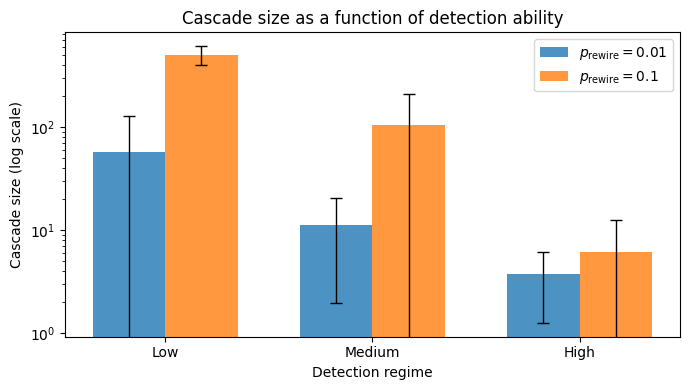

In [5]:
# 1) Cascade size vs detection regime
def plot_cascade_vs_detection_log(results_all, detection_regimes, p_rewire_values):
    x = np.arange(len(detection_regimes))
    width = 0.35

    fig, ax = plt.subplots(figsize=(7, 4))

    for idx, prewire in enumerate(p_rewire_values):
        means = []
        stds  = []
        for regime in detection_regimes:
            vals = results_all[(prewire, regime)]["cascades"]
            means.append(vals.mean())
            stds.append(vals.std())
        means = np.array(means)
        stds  = np.array(stds)

        offset = (idx - 0.5) * width
        ax.bar(x + offset, means, width,
               label=fr"$p_{{\mathrm{{rewire}}}}={prewire}$",
               alpha=0.8)

        ax.errorbar(x + offset, means, yerr=stds,
                    fmt='none', ecolor='black', elinewidth=1,
                    capsize=4)

    ax.set_xticks(x)
    ax.set_xticklabels(["Low", "Medium", "High"])
    ax.set_xlabel("Detection regime")
    ax.set_ylabel("Cascade size (log scale)")
    ax.set_title("Cascade size as a function of detection ability")
    ax.set_yscale("log")  # <--- LOG SCALE

    ax.legend()
    fig.tight_layout()
    plt.show()

plot_cascade_vs_detection_log(results_all, detection_regimes, p_rewire_values)

Plot: Average num_active(t) for low vs high detection
- Fix a rewiring value, e.g. p_rewire = 0.1 (the more “connected” network).
- Compare low vs high detection regimes on the same plot.

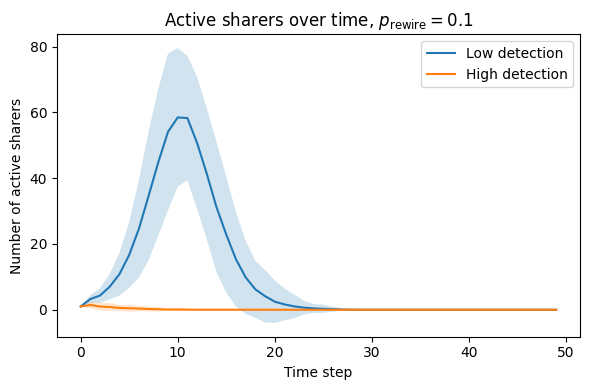

In [6]:
def plot_active_time_series(results_all, prewire_fixed, regimes_to_compare, T_max):
    fig, ax = plt.subplots(figsize=(6, 4))

    for regime in regimes_to_compare:
        data = results_all[(prewire_fixed, regime)]["num_active"]  # shape (n_runs, T_max)
        mean_active = data.mean(axis=0)
        std_active  = data.std(axis=0)

        t = np.arange(T_max)
        ax.plot(t, mean_active, label=f"{regime.capitalize()} detection")
        # optional: shaded std region
        ax.fill_between(t,
                        mean_active - std_active,
                        mean_active + std_active,
                        alpha=0.2)

    ax.set_xlabel("Time step")
    ax.set_ylabel("Number of active sharers")
    ax.set_title(fr"Active sharers over time, $p_{{\mathrm{{rewire}}}} = {prewire_fixed}$")
    ax.legend()
    fig.tight_layout()
    plt.show()

# Example: compare low vs high at p_rewire = 0.1
plot_active_time_series(results_all,
                        prewire_fixed=0.1,
                        regimes_to_compare=["low", "high"],
                        T_max=T_max)


each vs detection regime

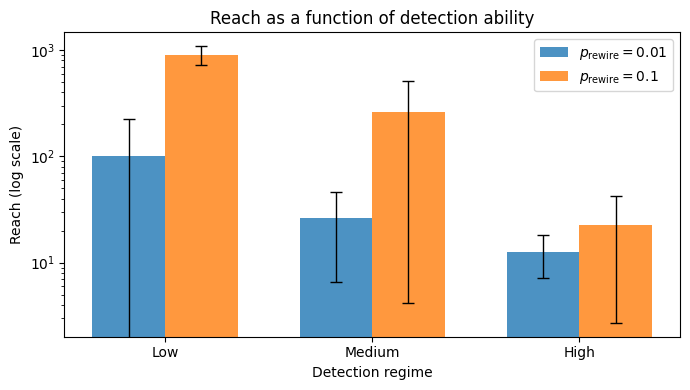

In [7]:
def plot_reach_vs_detection_log(results_all, detection_regimes, p_rewire_values):
    x = np.arange(len(detection_regimes))
    width = 0.35

    fig, ax = plt.subplots(figsize=(7, 4))

    for idx, prewire in enumerate(p_rewire_values):
        means = []
        stds  = []
        for regime in detection_regimes:
            vals = results_all[(prewire, regime)]["reaches"]
            means.append(vals.mean())
            stds.append(vals.std())
        means = np.array(means)
        stds  = np.array(stds)

        offset = (idx - 0.5) * width
        ax.bar(x + offset, means, width,
               label=fr"$p_{{\mathrm{{rewire}}}}={prewire}$",
               alpha=0.8)

        ax.errorbar(x + offset, means, yerr=stds,
                    fmt='none', ecolor='black', elinewidth=1,
                    capsize=4)

    ax.set_xticks(x)
    ax.set_xticklabels(["Low", "Medium", "High"])
    ax.set_xlabel("Detection regime")
    ax.set_ylabel("Reach (log scale)")
    ax.set_title("Reach as a function of detection ability")
    ax.set_yscale("log")

    ax.legend()
    fig.tight_layout()
    plt.show()

plot_reach_vs_detection_log(results_all, detection_regimes, p_rewire_values)


In [8]:
for prewire in p_rewire_values:
    ratios = []
    for regime in detection_regimes:
        casc = results_all[(prewire, regime)]["cascades"].mean()
        reach = results_all[(prewire, regime)]["reaches"].mean()
        ratios.append(reach / casc)
    print(prewire, ratios)

0.01 [np.float64(1.7649737302977233), np.float64(2.3232949512843226), np.float64(3.3941018766756033)]
0.1 [np.float64(1.785189718482252), np.float64(2.4952947954676397), np.float64(3.659127625201938)]


Plot: Reach/Cascade Ratio vs Detection Regime

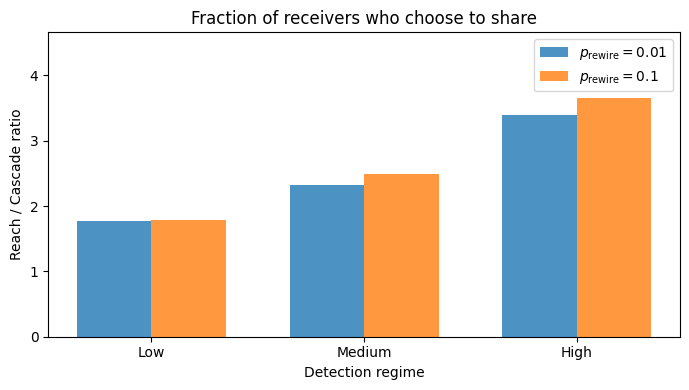

In [9]:
def plot_ratio_vs_detection(results_all, detection_regimes, p_rewire_values):
    x = np.arange(len(detection_regimes))
    width = 0.35

    fig, ax = plt.subplots(figsize=(7, 4))

    for idx, prewire in enumerate(p_rewire_values):
        ratios = []
        for regime in detection_regimes:
            casc = results_all[(prewire, regime)]["cascades"].mean()
            reach = results_all[(prewire, regime)]["reaches"].mean()
            ratios.append(reach / casc)

        ratios = np.array(ratios)

        offset = (idx - 0.5) * width
        ax.bar(x + offset, ratios, width,
               label=fr"$p_{{\mathrm{{rewire}}}}={prewire}$",
               alpha=0.8)

    ax.set_xticks(x)
    ax.set_xticklabels(["Low", "Medium", "High"])
    ax.set_xlabel("Detection regime")
    ax.set_ylabel("Reach / Cascade ratio")
    ax.set_title("Fraction of receivers who choose to share")
    ax.legend()
    ax.set_ylim(0, max(ratios) + 1)
    fig.tight_layout()
    plt.show()

plot_ratio_vs_detection(results_all, detection_regimes, p_rewire_values)